In [ ]:
import random
import os
from os.path import splitext
import csv
from pydub import AudioSegment, utils
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

INPUT_FOLDER = f"{os.getcwd()}/input"
OUTPUT_FOLDER = f"{os.getcwd()}/output"

VALID_AUDIO_EXTENSIONS =('.mp3', '.wav', '.flac', '.ogg', '.m4a', '.aac')
# get list of audio files in a folder ignoring any other files to prevent errors
def getListOfAudioFilesInFolder(folder_path):
  file_list = [file for file in os.listdir(folder_path) if file.endswith(VALID_AUDIO_EXTENSIONS)]
  return file_list

# Takes in a single audio clip and splits it into multiple clips of 10 seconds each.
def split_audio_into_windows(audio, window_duration=10000):
  windows = []
  audio_duration = len(audio)

  for start_time in range(0, audio_duration, window_duration):
    end_time = start_time + window_duration
    window = audio[start_time:end_time]
    windows.append(window)

  return windows

# Insert the gunshot audio into the background audio at a random interval.
def random_insertion(background_audio, gunshot_audio):
  try:
    # If gunshot_audio can fit, proceed with insertion
    if len(gunshot_audio) <= len(background_audio):
      start_time = random.randint(0, len(background_audio) - len(gunshot_audio))
      result = background_audio.overlay(gunshot_audio, position=start_time)

      return result
  except ValueError as e:
    # Ignore this case and return None
    print(f"Ignoring error: {e}")
    return

# Generate a spectrogram for the audio file and save it to the output file.
def generate_spectrogram(audio_segment, output_file, label):
  temp_audio = f"{OUTPUT_FOLDER}/audio/{output_file}.mp3"
  audio_segment.export(temp_audio, format="mp3")

  samples = librosa.load(temp_audio, sr=audio_segment.frame_rate)[0]
  # Z-normalize the samples
  # samples = (samples - np.mean(samples)) / np.std(samples)
  # Use librosa to compute a spectrogram
  spectrogram = librosa.feature.melspectrogram(y=samples, sr=audio_segment.frame_rate)
  # Convert amplitude to decibels
  log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

  # Plot and save the spectrogram
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(log_spectrogram, sr=audio_segment.frame_rate, x_axis='time', y_axis='linear')
  # plt.colorbar(format='%+2.0f dB')
  plt.axis('off')
  plt.savefig(f"{OUTPUT_FOLDER}/spectrograms/{output_file}", bbox_inches='tight', pad_inches=0)
  add_label_csv(output_file, label)
  # plt.show()
  os.remove(temp_audio)
  plt.close()

def add_label_csv(file_name, label):
  file_exists = os.path.isfile(f"{OUTPUT_FOLDER}/labels.csv")
  with open(f"{OUTPUT_FOLDER}/labels.csv", 'a', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=["file_name", "label"])

    if not file_exists: # Write header only if file does not exist
      writer.writeheader()

    writer.writerow({"file_name": file_name, "label": label})

# Create multiple variations of gunshot-inserted audio files.
def create_variations(window_duration=10000):
  """
    Each background audio file is split into windows of 10 seconds each.
    Each window is inserted with a real (1) or fake (0) gunshot audio.
    Each gunshot audio is inserted at 3 different volume levels (8%, 35%, 70%).
    Finally, each audio permutation (window x gun x volume) is exported as an spectrogram image.
  """
  background_folder = f"{INPUT_FOLDER}/background"
  gunshot_folder = f"{INPUT_FOLDER}/gunshot"
  non_gunshot_folder = f"{INPUT_FOLDER}/non-gunshot"
  background_files = getListOfAudioFilesInFolder(background_folder)
  gunshot_files = getListOfAudioFilesInFolder(gunshot_folder)
  non_gunshot_files = getListOfAudioFilesInFolder(non_gunshot_folder)

  for bg_file_name in background_files:
    bg_file_path = os.path.join(background_folder, bg_file_name)
    bg_audio = AudioSegment.from_file(bg_file_path)

    for i, window in enumerate(split_audio_into_windows(bg_audio, window_duration)):
      # Select a gunshot within 80% chance, otherwise select a non-gunshot
      include_gunshot = True
      if random.random() <= 0.8:
        selected_gunshot = random.choice(gunshot_files)
        gunshot_audio = AudioSegment.from_file(os.path.join(gunshot_folder, selected_gunshot))
      else: # 20% chance of selecting a non-gunshot
        include_gunshot = False
        selected_gunshot = random.choice(non_gunshot_files)
        gunshot_audio = AudioSegment.from_file(os.path.join(non_gunshot_folder, selected_gunshot))

      # Normalize the audio segments to prevent clipping
      window = window.normalize()
      gunshot_audio = gunshot_audio.normalize()

      window_name = f"{splitext(bg_file_name)[0]}_window={i+1}"

      # Generate a clean spectrogram (the original background window without a gunshot)
      generate_spectrogram(window, f"{window_name}_gun=0.png", 0)

      # Insert the gunshot into the background window and create different copies for each volume level
      for volume in [0.08, 0.35, 0.70]:
        modified_gunshot = gunshot_audio.apply_gain(utils.ratio_to_db(volume))
        result_audio = random_insertion(window, modified_gunshot)

        if result_audio is not None:
          result_audio = result_audio.normalize()
          label = 1 if include_gunshot else 0
          output_filename = f"{window_name}_vol={int(volume * 100)}%_gun={label}"

          # Export result audio as mp3
          # result_audio.export(f"{OUTPUT_FOLDER}/audio/{output_filename}.mp3", format="mp3")
          # Generate the spectrogram for the result audio
          generate_spectrogram(result_audio, f"{output_filename}.png", label)


ModuleNotFoundError: ignored

In [ ]:
# RUN
create_variations()

# Loading spetrogram dataset into pytorch

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd  /content/drive/'MyDrive'/CV/'CV Project'/'Computer-Vision-Project'/

Mounted at /content/drive
/content/drive/MyDrive/CV/CV Project/Computer-Vision-Project


In [2]:
import random
import os
from os.path import splitext
import csv
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)

device:  cpu


### Peeking into the labels data frame

In [4]:
INPUT_FOLDER = f"{os.getcwd()}/input"
OUTPUT_FOLDER = f"{os.getcwd()}/output"

In [5]:
SPECTROGRAMS_FOLDER = f"{OUTPUT_FOLDER}/spectrograms"
data_frame = pd.read_csv(f"{OUTPUT_FOLDER}/labels.csv")

print(data_frame.head(), '\n')
print(data_frame['label'].value_counts().rename(index={0: 'No gun/Fake gun (0)', 1: 'Real gun (1)'}))

                                     file_name  label
0          southcentre_mall_window=1_gun=0.png      0
1   southcentre_mall_window=1_vol=8%_gun=1.png      1
2  southcentre_mall_window=1_vol=35%_gun=1.png      1
3  southcentre_mall_window=1_vol=70%_gun=1.png      1
4          southcentre_mall_window=2_gun=0.png      0 

Real gun (1)           6855
No gun/Fake gun (0)    4677
Name: label, dtype: int64


### Creating a custom dataset for the train_loader and test_loader

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, data_frame=None, transform=None):
    self.data_frame = data_frame
    self.transform = transform

  def __len__(self):
    return len(self.data_frame)

  def __getitem__(self, idx):
    img_name = self.data_frame.iloc[idx, 0]
    image = Image.open(f'{SPECTROGRAMS_FOLDER}/{img_name}').convert('RGB')
    label = int(self.data_frame.iloc[idx, 1])

    if self.transform:
        image = self.transform(image)

    return image, label

"""
Resize the image to standard size, most pretrained models use 224x224.
If we also use this resolution we can experiment with the built-in pretrained models from torchvision.
"""
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

whole_dataset = CustomDataset(data_frame=data_frame, transform=transform)

# Split the dataset into training and testing sets
train_dataset, test_dataset = train_test_split(whole_dataset, test_size=0.2, random_state=42)

# Create DataLoader instances for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
import sys
print(sys.getsizeof(train_loader))

48


In [ ]:
torch.save(train_loader, 'train_loader.pth')

In [ ]:
torch.save(test_loader, 'test_loader.pth')

In [6]:
train_loader = torch.load('train_loader.pth')
test_loader = torch.load('test_loader.pth')

### Looking into the dataloaders exactly as pytorch will receive them:

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# plot images and labels with no padding
fig = plt.figure(figsize=(16, 16))
for idx in np.arange(64):
  ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(f'{"gun (1)" if labels[idx] == 1 else "No gun (0)"}')


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def train(model, train_loader, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      data = data.to(device)
      target = target.to(device)

      optimizer.zero_grad()
      output = model(data)
      loss = F.cross_entropy(output, target).to(device)
      loss.backward()
      optimizer.step()
      if batch_idx % 25 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

def validation(model, test_loader):
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)

      output = model(data)
      validation_loss += F.cross_entropy(output, target, reduction="sum").to(device).item() # sum up batch loss
      pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
      correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(test_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return 100. * correct / len(test_loader.dataset)

def plot_accuracy(num_epochs, acc_perc_list, filename="plot.png"):
  plt.plot(range(num_epochs+1), acc_perc_list)
  plt.xlim([0,num_epochs+1])
  plt.ylim([50,100])
  plt.xticks([0, 5, 15, 20])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy %')
  plt.savefig(filename)
  plt.show();

def run(model, train_loader, test_loader, num_epochs):
  acc_perc_list = []
  acc_perc = validation(model, test_loader)
  acc_perc_list.append(acc_perc)

  for epoch in range(1, num_epochs + 1):
      train(model, train_loader, epoch)
      scheduler.step()
      acc_perc = validation(model, test_loader)
      acc_perc_list.append(acc_perc)

  return acc_perc_list
  # plot_accuracy(num_epochs, acc_perc_list)

Model 1:

max_pool2d(relu(conv1(x)), 2)
bn2d1(x)

max_pool2d(relu(conv2(x)), 2)
batchnorm2d2(x)

flatten
relu(fullyconnected1(x))
dropout(x)
fullyconnected2(x)

In [ ]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(3, 48, kernel_size=3, padding=1)

      self.bn2d1 = nn.BatchNorm2d(48, affine=True)

      self.conv2 = nn.Conv2d(48, 64, kernel_size=3, padding=1)

      self.bn2d2 = nn.BatchNorm2d(64, affine=True)

      self.fc1 = nn.Linear(56*56*64, 128)

      self.dropout = nn.Dropout()

      self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2)
      x = self.bn2d1(x)

      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2)
      x = self.bn2d2(x)

      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))

      x = self.dropout(x)

      x = self.fc2(x)

      return F.log_softmax(x,dim=1)

model_1 = Net()
model_1 = model_1.to(device)

optimizer = optim.Adam(model_1.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 20

In [ ]:
acc_perc_list = run(model_1, train_loader, test_loader, num_epochs)


Validation set: Average loss: 0.7030, Accuracy: 954/2307 (41%)

Train Epoch: 1 [0/9225 (0%)]	Loss: 0.724571
Train Epoch: 1 [1600/9225 (17%)]	Loss: 0.711837
Train Epoch: 1 [3200/9225 (34%)]	Loss: 0.715499
Train Epoch: 1 [4800/9225 (52%)]	Loss: 0.637128
Train Epoch: 1 [6400/9225 (69%)]	Loss: 0.659835
Train Epoch: 1 [8000/9225 (86%)]	Loss: 0.763006

Validation set: Average loss: 0.6775, Accuracy: 1378/2307 (60%)

Train Epoch: 2 [0/9225 (0%)]	Loss: 0.706632
Train Epoch: 2 [1600/9225 (17%)]	Loss: 0.634791
Train Epoch: 2 [3200/9225 (34%)]	Loss: 0.687786
Train Epoch: 2 [4800/9225 (52%)]	Loss: 0.654672
Train Epoch: 2 [6400/9225 (69%)]	Loss: 0.656340
Train Epoch: 2 [8000/9225 (86%)]	Loss: 0.656860

Validation set: Average loss: 0.6478, Accuracy: 1526/2307 (66%)

Train Epoch: 3 [0/9225 (0%)]	Loss: 0.666421
Train Epoch: 3 [1600/9225 (17%)]	Loss: 0.663774
Train Epoch: 3 [3200/9225 (34%)]	Loss: 0.579991
Train Epoch: 3 [4800/9225 (52%)]	Loss: 0.603386
Train Epoch: 3 [6400/9225 (69%)]	Loss: 0.629745

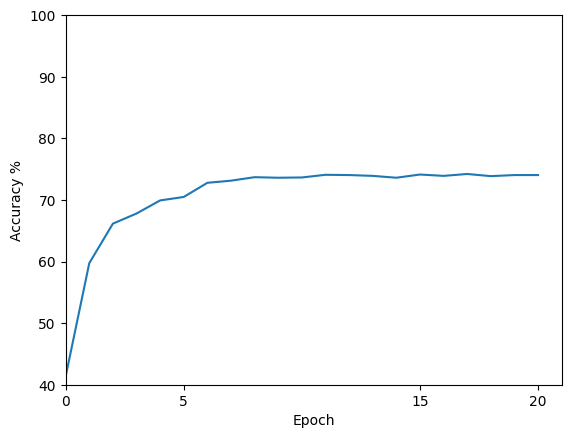

In [ ]:
plot_accuracy(num_epochs, acc_perc_list, 'model_1_lr=1e4_wd=1e5.png')

In [ ]:
# acc_perc_list
[float(x) for x in acc_perc_list]

[41.3524055480957,
 59.73125457763672,
 66.1465072631836,
 67.79367065429688,
 69.91764068603516,
 70.48114776611328,
 72.77850341796875,
 73.12527465820312,
 73.68877410888672,
 73.60208129882812,
 73.64542388916016,
 74.07888793945312,
 74.0355453491211,
 73.90550231933594,
 73.60208129882812,
 74.12223815917969,
 73.90550231933594,
 74.20893096923828,
 73.8621597290039,
 74.0355453491211,
 74.0355453491211]

In [ ]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
      # self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

      self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
      # self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

      self.fc1 = nn.Linear(56*56*64, 64)
      self.bn = nn.BatchNorm1d(64)

      self.dropout = nn.Dropout()
      self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      # x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2)

      x = F.relu(self.conv3(x))
      # x = F.relu(self.conv4(x))
      x = F.max_pool2d(x, 2)

      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))
      x = self.bn(x)
      x = self.dropout(x)

      x = self.fc2(x)

      return F.log_softmax(x,dim=1)

model_2 = Net()
model_2 = model_2.to(device)

optimizer = optim.Adam(model_2.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 20

In [ ]:
acc_perc_list = run(model_2, train_loader, test_loader, num_epochs)


Validation set: Average loss: 0.7028, Accuracy: 954/2307 (41%)

Train Epoch: 1 [0/9225 (0%)]	Loss: 0.746688
Train Epoch: 1 [1600/9225 (17%)]	Loss: 0.736200
Train Epoch: 1 [3200/9225 (34%)]	Loss: 0.697963
Train Epoch: 1 [4800/9225 (52%)]	Loss: 0.754591
Train Epoch: 1 [6400/9225 (69%)]	Loss: 0.708748
Train Epoch: 1 [8000/9225 (86%)]	Loss: 0.738370

Validation set: Average loss: 0.7116, Accuracy: 1186/2307 (51%)

Train Epoch: 2 [0/9225 (0%)]	Loss: 0.696435
Train Epoch: 2 [1600/9225 (17%)]	Loss: 0.728616
Train Epoch: 2 [3200/9225 (34%)]	Loss: 0.674147
Train Epoch: 2 [4800/9225 (52%)]	Loss: 0.719584
Train Epoch: 2 [6400/9225 (69%)]	Loss: 0.651702
Train Epoch: 2 [8000/9225 (86%)]	Loss: 0.492173

Validation set: Average loss: 0.6324, Accuracy: 1492/2307 (65%)

Train Epoch: 3 [0/9225 (0%)]	Loss: 0.679070
Train Epoch: 3 [1600/9225 (17%)]	Loss: 0.517936
Train Epoch: 3 [3200/9225 (34%)]	Loss: 0.600748
Train Epoch: 3 [4800/9225 (52%)]	Loss: 0.576582
Train Epoch: 3 [6400/9225 (69%)]	Loss: 0.506230

In [ ]:
[float(x) for x in acc_perc_list]

[41.3524055480957,
 51.408756256103516,
 64.67273712158203,
 67.57694244384766,
 73.8621597290039,
 61.03164291381836,
 75.55266571044922,
 71.91157531738281,
 75.68270111083984,
 72.82184600830078,
 67.4468994140625,
 73.60208129882812,
 74.07888793945312,
 72.34503936767578,
 73.47203826904297,
 73.9488525390625,
 72.0849609375,
 72.73515319824219,
 73.8621597290039,
 72.86519622802734,
 72.86519622802734]

In [ ]:
model_3 = models.resnet18(pretrained=False)

num_features = model_3.fc.in_features
model_3.fc = nn.Linear(num_features, 2)

for param in model_3.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in model_3.fc.parameters():
    param.requires_grad = True

model_3 = model_3.to(device)

optimizer = optim.Adam(model_3.fc.parameters(), lr=0.0001)

num_epochs = 20

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
acc_perc_list = run(model_3, train_loader, test_loader, num_epochs)


Validation set: Average loss: 0.7285, Accuracy: 948/2307 (41%)

Train Epoch: 1 [0/9225 (0%)]	Loss: 0.797578
Train Epoch: 1 [1600/9225 (17%)]	Loss: 0.595594
Train Epoch: 1 [3200/9225 (34%)]	Loss: 0.680955
Train Epoch: 1 [4800/9225 (52%)]	Loss: 0.622497
Train Epoch: 1 [6400/9225 (69%)]	Loss: 0.682188
Train Epoch: 1 [8000/9225 (86%)]	Loss: 0.587192

Validation set: Average loss: 0.6735, Accuracy: 1349/2307 (58%)

Train Epoch: 2 [0/9225 (0%)]	Loss: 0.693084
Train Epoch: 2 [1600/9225 (17%)]	Loss: 0.635160
Train Epoch: 2 [3200/9225 (34%)]	Loss: 0.653736
Train Epoch: 2 [4800/9225 (52%)]	Loss: 0.681022
Train Epoch: 2 [6400/9225 (69%)]	Loss: 0.658552
Train Epoch: 2 [8000/9225 (86%)]	Loss: 0.632125

Validation set: Average loss: 0.6362, Accuracy: 1438/2307 (62%)

Train Epoch: 3 [0/9225 (0%)]	Loss: 0.617177
Train Epoch: 3 [1600/9225 (17%)]	Loss: 0.614679
Train Epoch: 3 [3200/9225 (34%)]	Loss: 0.644031
Train Epoch: 3 [4800/9225 (52%)]	Loss: 0.593685
Train Epoch: 3 [6400/9225 (69%)]	Loss: 0.613882

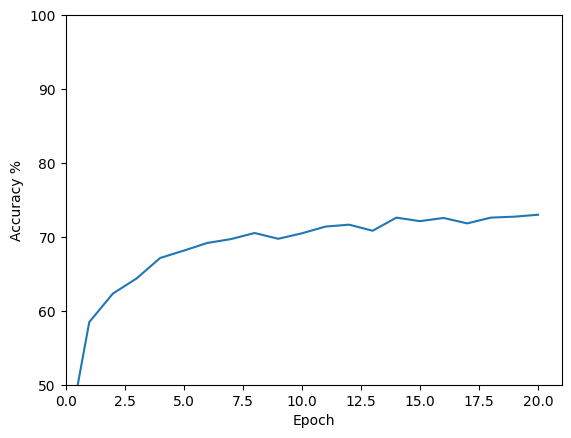

In [ ]:
plot_accuracy(num_epochs, acc_perc_list)

In [ ]:
import gc
gc.collect()
torch.empty_cache()